# TensorFlow Hub and Transfer Learning

[TensorFlow Hub](http://tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use.
These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

You can find all the models available in [TensorFlow Module Hub](https://tfhub.dev/).

If you are using Google Colab (which is the chief assumption for this project), before starting this Colab, you should reset the Colab environment by selecting `Runtime -> Reset all runtimes...` from menu above.

# Imports



This Colab will require us to use some things which are not yet in official releases of TensorFlow. So below, we're first installing a nightly version of TensorFlow as well as TensorFlow Hub.

This will switch your installation of TensorFlow in Colab to this TensorFlow version. Once you are finished with this Colab, you should switch batch to the latest stable release of TensorFlow by selecting `Runtime -> Reset all runtimes...` in the menus above. This will reset the Colab environment to its original state.

In [0]:
!pip install tf-nightly-gpu
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.1.0)


Some normal imports we've seen before. The new one is importing tensorflow_hub which was installed above, and which this Colab will make heavy use of.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Part 1: Setting up the MobileNet Classifier

The model that we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) would work).

Download the MobileNet model and create a Keras model from it.
MobileNet is expecting images of 224 $\times$ 224 pixels, in 3 color channels (RGB).

In [0]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

# Part 2: Use the TensorFlow Hub MobileNet model for the Cats vs. Dogs dataset

Now we'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset.

## Dataset

We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


W0807 12:25:53.769792 139668789077888 cats_vs_dogs.py:117] 1738 images were corrupted and were skipped


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


The images in the Dogs vs. Cats dataset are not all the same size.

In [0]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)


So we need to reformat all images to the resolution expected by MobileNet (224, 224).

The `.repeat()` and `steps_per_epoch` here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Run the classifier on a batch of images

Remember our `model` object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes.
ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.


In [0]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['hamper', 'tabby', 'tabby', 'American Staffordshire terrier',
       'kelpie', 'plate rack', 'Doberman', 'Egyptian cat', 'Egyptian cat',
       'toilet seat', 'kuvasz', 'tabby', 'paper towel', 'bloodhound',
       'tiger cat', 'Irish terrier', 'tabby', 'malinois', 'tabby',
       'Great Pyrenees', 'toilet seat', 'Egyptian cat', 'Cardigan',
       'tiger cat', 'Rottweiler', 'miniature poodle', 'Persian cat',
       'Ibizan hound', 'Lhasa', 'lynx', 'tabby', 'basset'], dtype='<U30')

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.

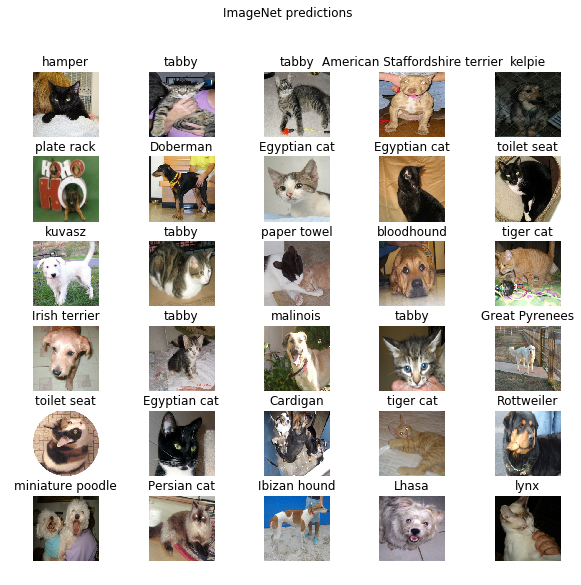

In [0]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

**Generally, the learnings are good, but we have a few weird predictions, like 'toilet seat', 'cardigan' and 'paper towel'. OUR MODEL SHOULD BE ABLE TO DO BETTER.**

# Part 3: Do simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using [TensorFlow Lite](https://www.tensorflow.org/lite). Any [image feature vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [0]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [0]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [0]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

We now train this model like any other, by first calling `compile` followed by `fit`.

In [0]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 52s 90ms/step - loss: 0.2269 - acc: 0.9403 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
582/582 [==============================] - 43s 74ms/step - loss: 0.1840 - acc: 0.9608 - val_loss: 0.1736 - val_acc: 0.9659
Epoch 3/6
582/582 [==============================] - 44s 75ms/step - loss: 0.1758 - acc: 0.9643 - val_loss: 0.1731 - val_acc: 0.9662
Epoch 4/6
582/582 [==============================] - 43s 75ms/step - loss: 0.1708 - acc: 0.9662 - val_loss: 0.1740 - val_acc: 0.9664
Epoch 5/6
582/582 [==============================] - 44s 75ms/step - loss: 0.1672 - acc: 0.9679 - val_loss: 0.1754 - val_acc: 0.9655
Epoch 6/6
582/582 [==============================] - 43s 74ms/step - loss: 0.1643 - acc: 0.9695 - val_loss: 0.1769 - val_acc: 0.9644


You can see we get **~97%** validation accuracy, which is absolutely awesome. This is a huge improvement over the model we created in Cats_Vs_Dogs_Improved, where we were able to get ~83% accuracy. **The reason for this difference is that MobileNet was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).**

Although not equivalent to TensorFlow Hub, you can check out how to create MobileNet in Keras [here](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py).

Let's plot the training and validation accuracy/loss graphs.

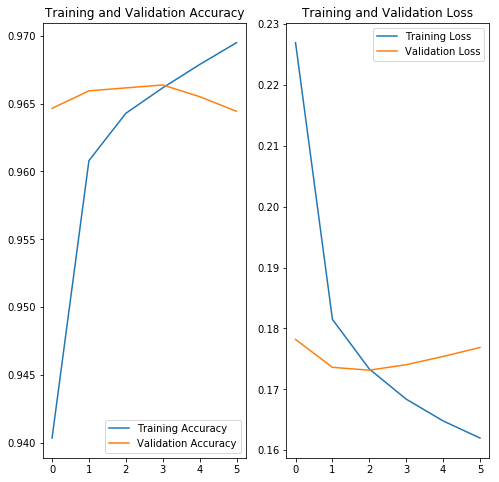

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

## Check the predictions

To redo the plot from before, first get the ordered list of class names.

In [0]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run the image batch through the model and convert the indices to class names.

In [0]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat',
       'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog',
       'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat',
       'dog', 'dog', 'cat', 'cat', 'dog'], dtype='<U3')

Let's look at the true labels and predicted ones.

In [0]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1]
Predicted labels:  [0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1]


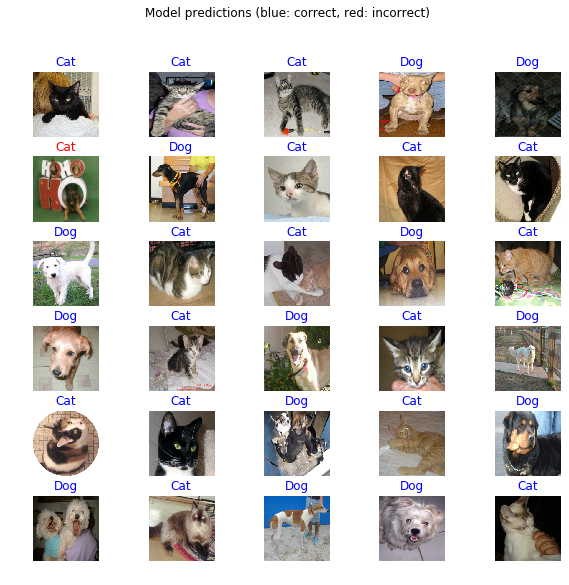

In [0]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

### Note the improvements:
1. Training times were a whole lot faster. We used just 6 epochs, with the  best performance around epoch 3.
2. Accuracy improved from about 83% to about 97%.
3. Our learning graphs were a lot smoother.
